**The Sparks Foundation**

#### Task 05 : Traffic Sign Classification/Recognition System

**Made By:**
- U.Kishore
- Data Scientist
- MBA (Business Analytics), Data Science Bootcamp, B.com
- Sparks Foundation Internship


### Traffic Sign Classification using Torchvision, Pytorch and Python

using Transfer Learning to classify traffic sign images. 

*   using Transfer Learning to classify traffic sign images. 



*   building a dataset of images in a format suitable for working with Torchvision.
*   Get predictions on images from the wild (downloaded from the Internet).


Here's what we'll go over:

- Overview of the traffic sign image dataset
- Build a dataset
- Use a pre-trained model from Torchvision
- Add a new *unknown* class and re-train the model



In [ ]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Recognizing traffic signs

[German Traffic Sign Recognition Benchmark (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) contains more than 50,000 annotated images of 40+ traffic signs. Given an image, you'll have to recognize the traffic sign on it.



In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2021-11-19 21:54:06--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  23.8MB/s    in 12s     

2021-11-19 21:54:19 (21.6 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



### Exploration

The images for each traffic sign are stored in a separate directory. How many do we have?

In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

Create 3 helper functions that use OpenCV and Torchvision to load  and show images:

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Take a look at some examples for each traffic sign:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  app.launch_new_instance()


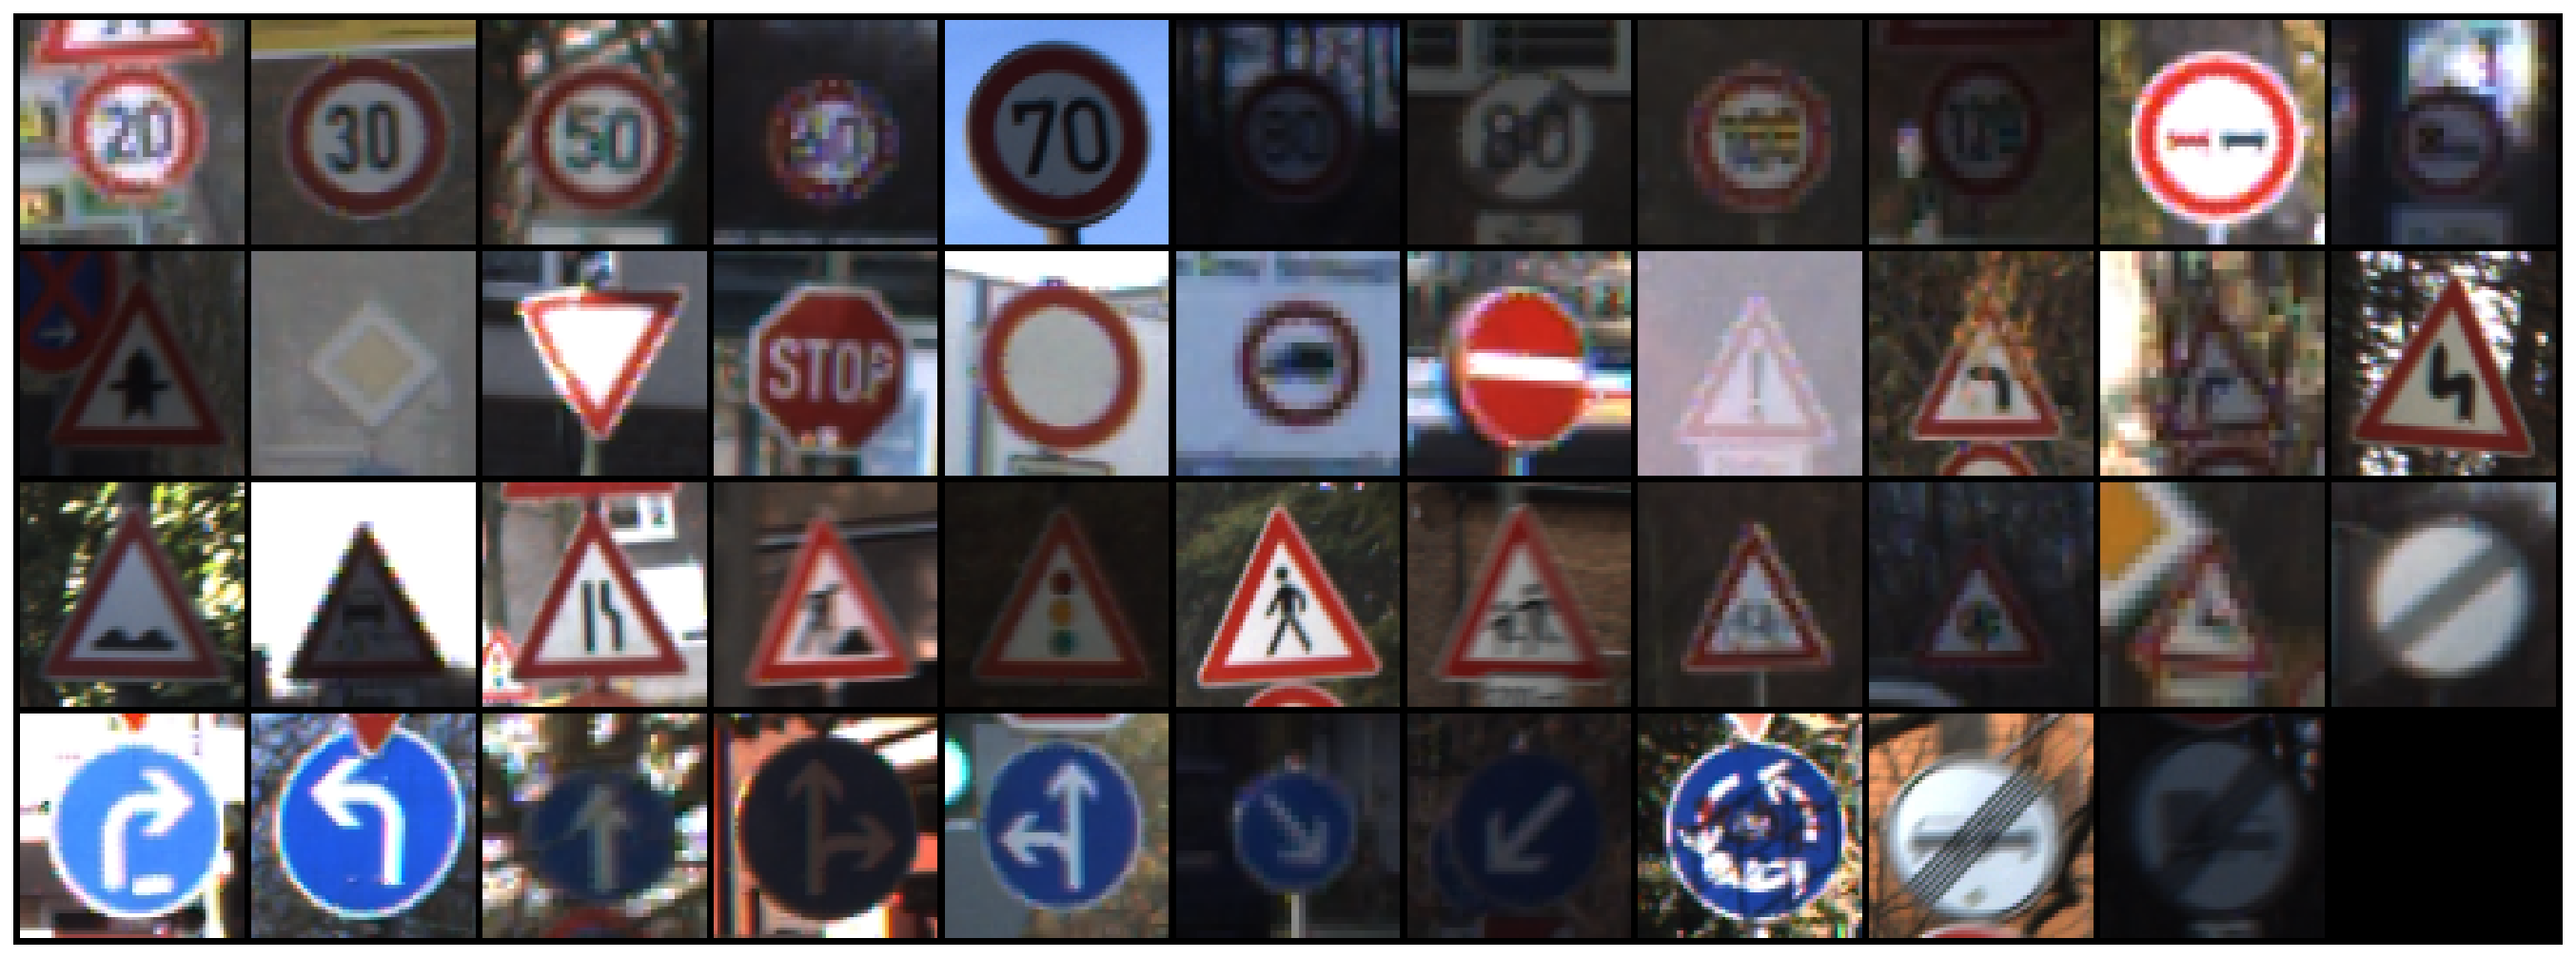

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

And here is a single sign:

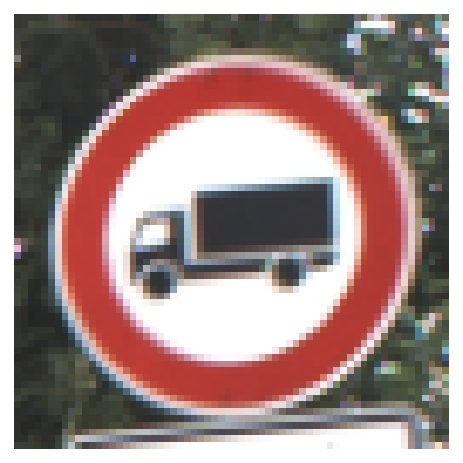

In [ ]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

show_image(img_path)

## Building a dataset

To keep things simple, focus on classifying some of the most used traffic signs:

In [ ]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']

class_indices = [12, 13, 14, 17]

Copy the images files to a new directory, so it's easier to use the Torchvision's dataset helpers:

In [ ]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

Reserve 80% of the images for training, 10% for validation, and 10% test for each class. Copy each image to the correct dataset directory:

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110



Apply some image augmentation techniques to artificially increase the size of our training dataset:

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

Apply resizing, rotation, and horizontal flips. Finally, we normalize the tensors using preset values for each channel. This is a [requirement of the pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html) in Torchvision.

Create a PyTorch dataset for each image dataset folder and data loaders for easier training:

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Store the number of examples in each dataset and class names for later:

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 615, 'train': 4920, 'val': 615}

Look at some example images with applied transformations. We also need to reverse the normalization and reorder the color channels to get correct image data:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


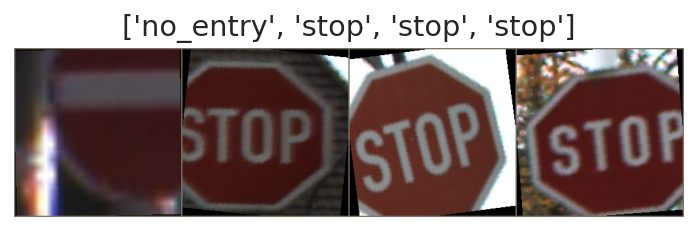

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Using a pre-trained model:

The model will receive raw image pixels and try to classify them into one of four traffic signs. How hard can it be? Try to build a model from scratch.

Here, we'll use [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning) to copy the architecture of the very popular [ResNet](https://arxiv.org/abs/1512.03385) model. On top of that, we'll use the learned weights of the model from training on the [ImageNet dataset ](http://www.image-net.org/). All of this is made easy to use by Torchvision:

In [ ]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

We reuse almost everything except the change of the output layer. This is needed because the number of classes in our dataset is different than ImageNet.

Let's create an instance of our model:

In [ ]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

### Training

Write 3 helper functions to encapsulate the training and evaluation logic. Let's start with `train_epoch`:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

Turning our model into train mode and go over the data. 
After getting the predictions, we get the class with maximum probability along with the loss, so we can calculate the epoch loss and accuracy.

Note that we're also using a learning rate scheduler (more on that later).

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

The evaluation of the model is pretty similar, except that we don't do any gradient calculations.



In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history



Let's train our first model:

In [ ]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.32820408362812437 accuracy 0.8896341463414634
Val   loss 0.01528969125842219 accuracy 0.9983739837398374

Epoch 2/3
----------
Train loss 0.11597867678243436 accuracy 0.9607723577235773
Val   loss 0.016209530147102077 accuracy 0.9934959349593496

Epoch 3/3
----------
Train loss 0.07484844636314736 accuracy 0.9741869918699188
Val   loss 0.00032969350073463154 accuracy 1.0

Best val accuracy: 1.0
CPU times: user 14min 50s, sys: 7.81 s, total: 14min 58s
Wall time: 15min 3s


Helper function that visualizes the training history :

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

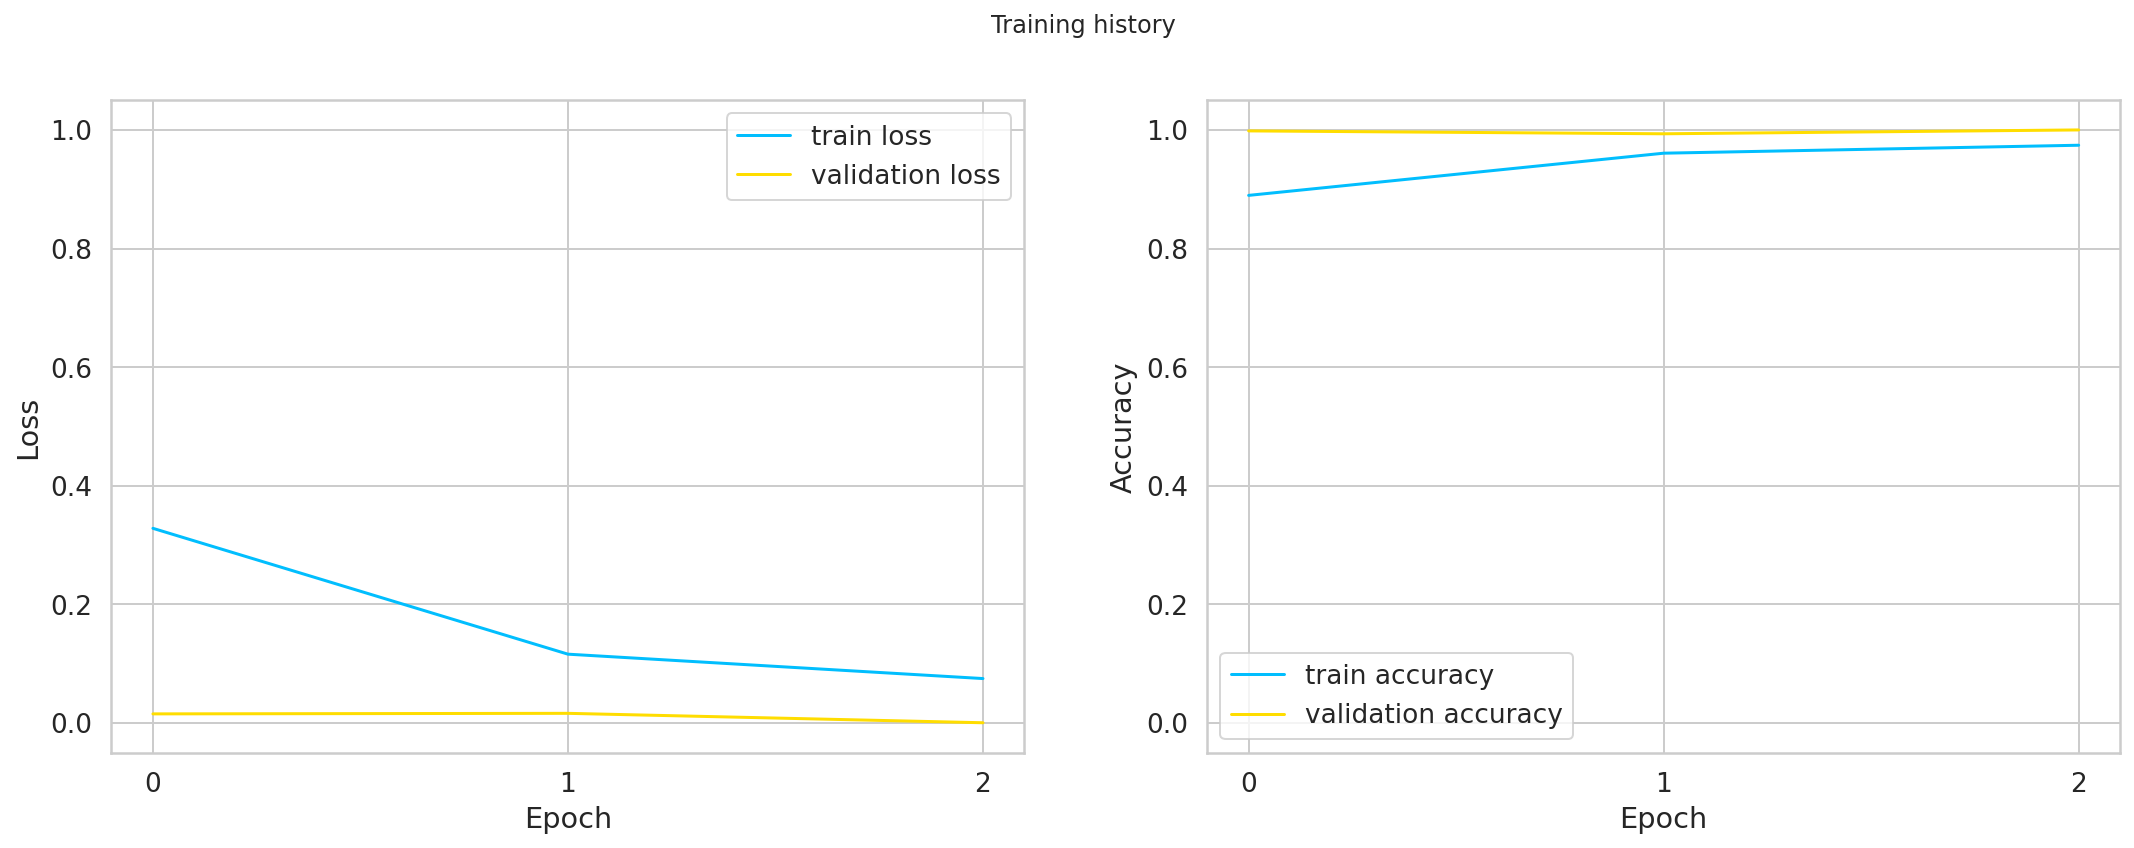

In [ ]:
plot_training_history(history)

The pre-trained model is so good that we get very high accuracy and low loss after 3 epochs. Unfortunately, our validation set is too small to get some meaningful metrics from it.

### Evaluation

Predictions on traffic signs from the test set:

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


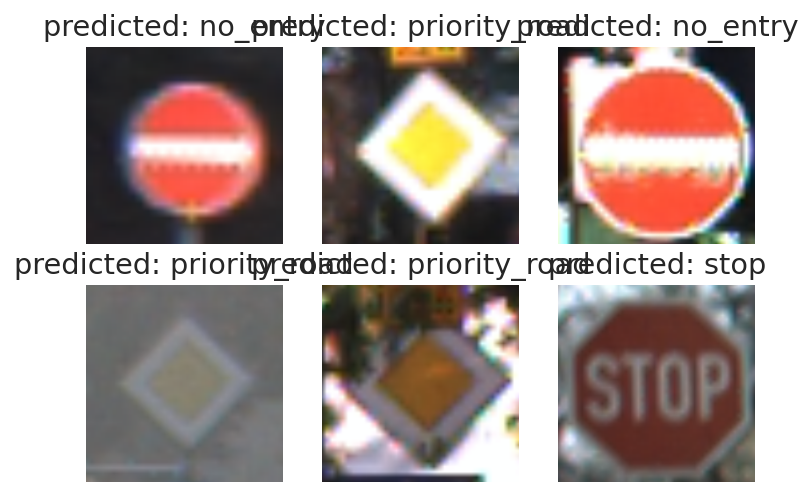

In [ ]:
show_predictions(base_model, class_names, n_images=4)

Even the almost not visible *priority road* sign is classified correctly. Let's dive a bit deeper.

Getting the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       111
priority_road       1.00      1.00      1.00       210
         stop       1.00      1.00      1.00        78

     accuracy                           1.00       615
    macro avg       1.00      1.00      1.00       615
 weighted avg       1.00      1.00      1.00       615



### Classifying unseen images

The model will be when confronted with a real-world image? Let's check it out:

In [ ]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 28.2MB/s]


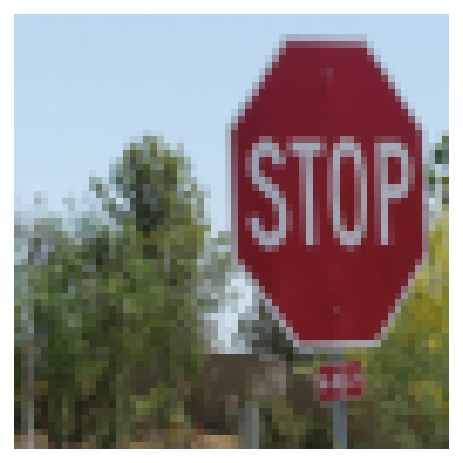

In [ ]:
show_image('stop-sign.jpg')

For this, we'll have a look at the confidence for each class. Let's get this from our model:

In [ ]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [ ]:
pred = predict_proba(base_model, 'stop-sign.jpg')
pred

array([0.02754086, 0.20446904, 0.02993101, 0.73805904], dtype=float32)

This is a bit hard to understand. Let's plot it:

In [ ]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

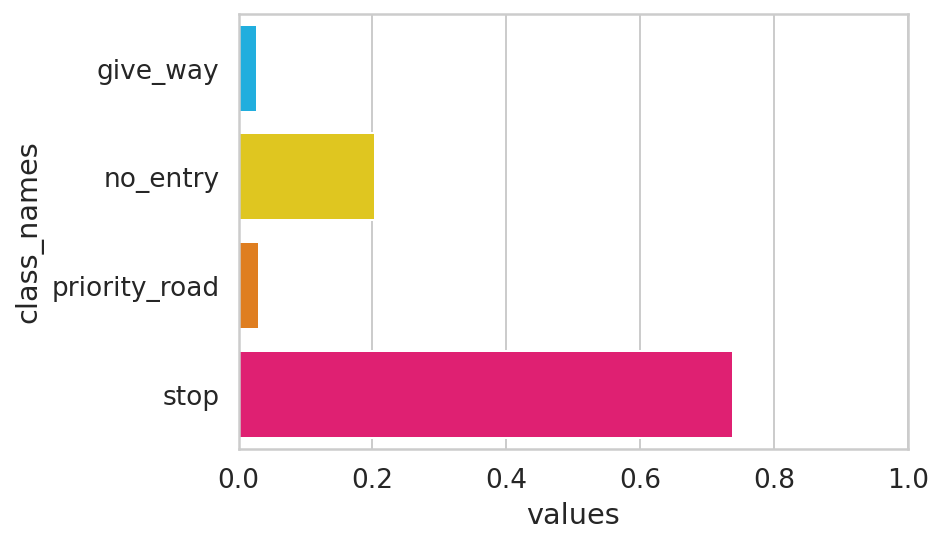

In [ ]:
show_prediction_confidence(pred, class_names)

Again, our model is performing very well! Really confident in the correct traffic sign!

### Classyfing unknown traffic sign

The last challenge for our model is a traffic sign that it hasn't seen before:

In [ ]:
!gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u

Downloading...
From: https://drive.google.com/uc?id=1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
To: /content/unknown-sign.jpg
100% 41.4k/41.4k [00:00<00:00, 15.6MB/s]


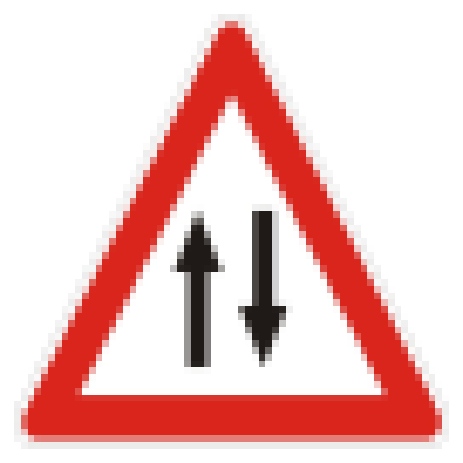

In [ ]:
show_image('unknown-sign.jpg')

Let's get the predictions:

In [ ]:
pred = predict_proba(base_model, 'unknown-sign.jpg')
pred

array([9.9993479e-01, 2.7020374e-07, 4.9776911e-05, 1.5114805e-05],
      dtype=float32)

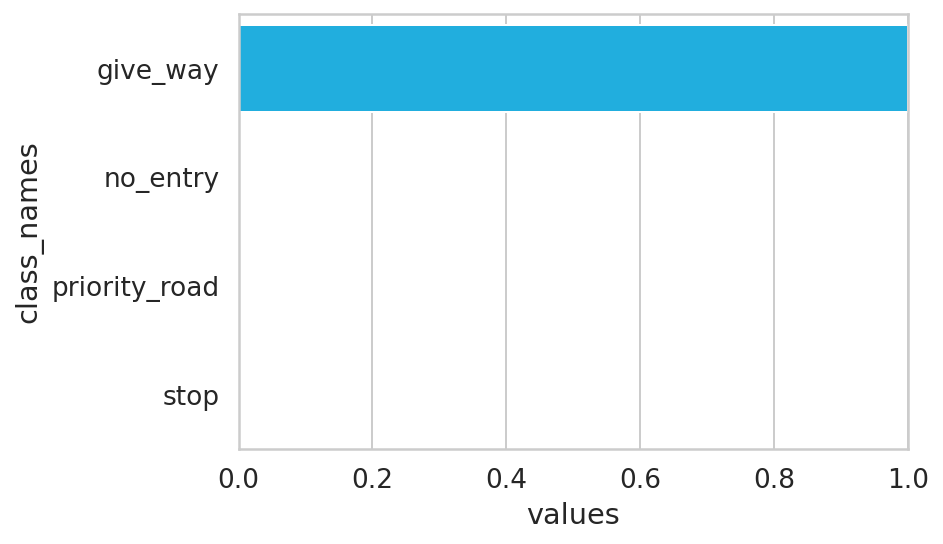

In [ ]:
show_prediction_confidence(pred, class_names)

Our model is very certain (more than 95% confidence) that this is a *give way* sign. This is obviously wrong. How can you make your model see this?

## Adding class "unknown"



We'll get the indices of all traffic signs that weren't included in our original dataset:

In [ ]:
unknown_indices = [
  i for i, f in enumerate(train_folders) \
  if i not in class_indices
]

len(unknown_indices)

39

Create a new folder for the unknown class and copy some of the images there:

In [ ]:
for ds in DATASETS:
  (DATA_DIR / ds / 'unknown').mkdir(parents=True, exist_ok=True)

for ui in unknown_indices:
  image_paths = np.array(glob(f'{train_folders[ui]}/*.ppm'))
  image_paths = np.random.choice(image_paths, 50)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/unknown/')

The next steps are identical to what we've already done:

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'test': 786, 'train': 5716, 'val': 782}

In [ ]:
%%time

enchanced_model = create_model(len(class_names))
enchanced_model, history = train_model(enchanced_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.37234062140774027 accuracy 0.870888733379986
Val   loss 0.01304011271008212 accuracy 0.9961636828644502

Epoch 2/3
----------
Train loss 0.1711082915722871 accuracy 0.9508397480755773
Val   loss 0.018865843447730762 accuracy 0.9948849104859336

Epoch 3/3
----------
Train loss 0.13579722949335418 accuracy 0.9595871238628411
Val   loss 0.01775138194501806 accuracy 0.9936061381074169

Best val accuracy: 0.9961636828644502
CPU times: user 17min 17s, sys: 9.18 s, total: 17min 26s
Wall time: 17min 31s


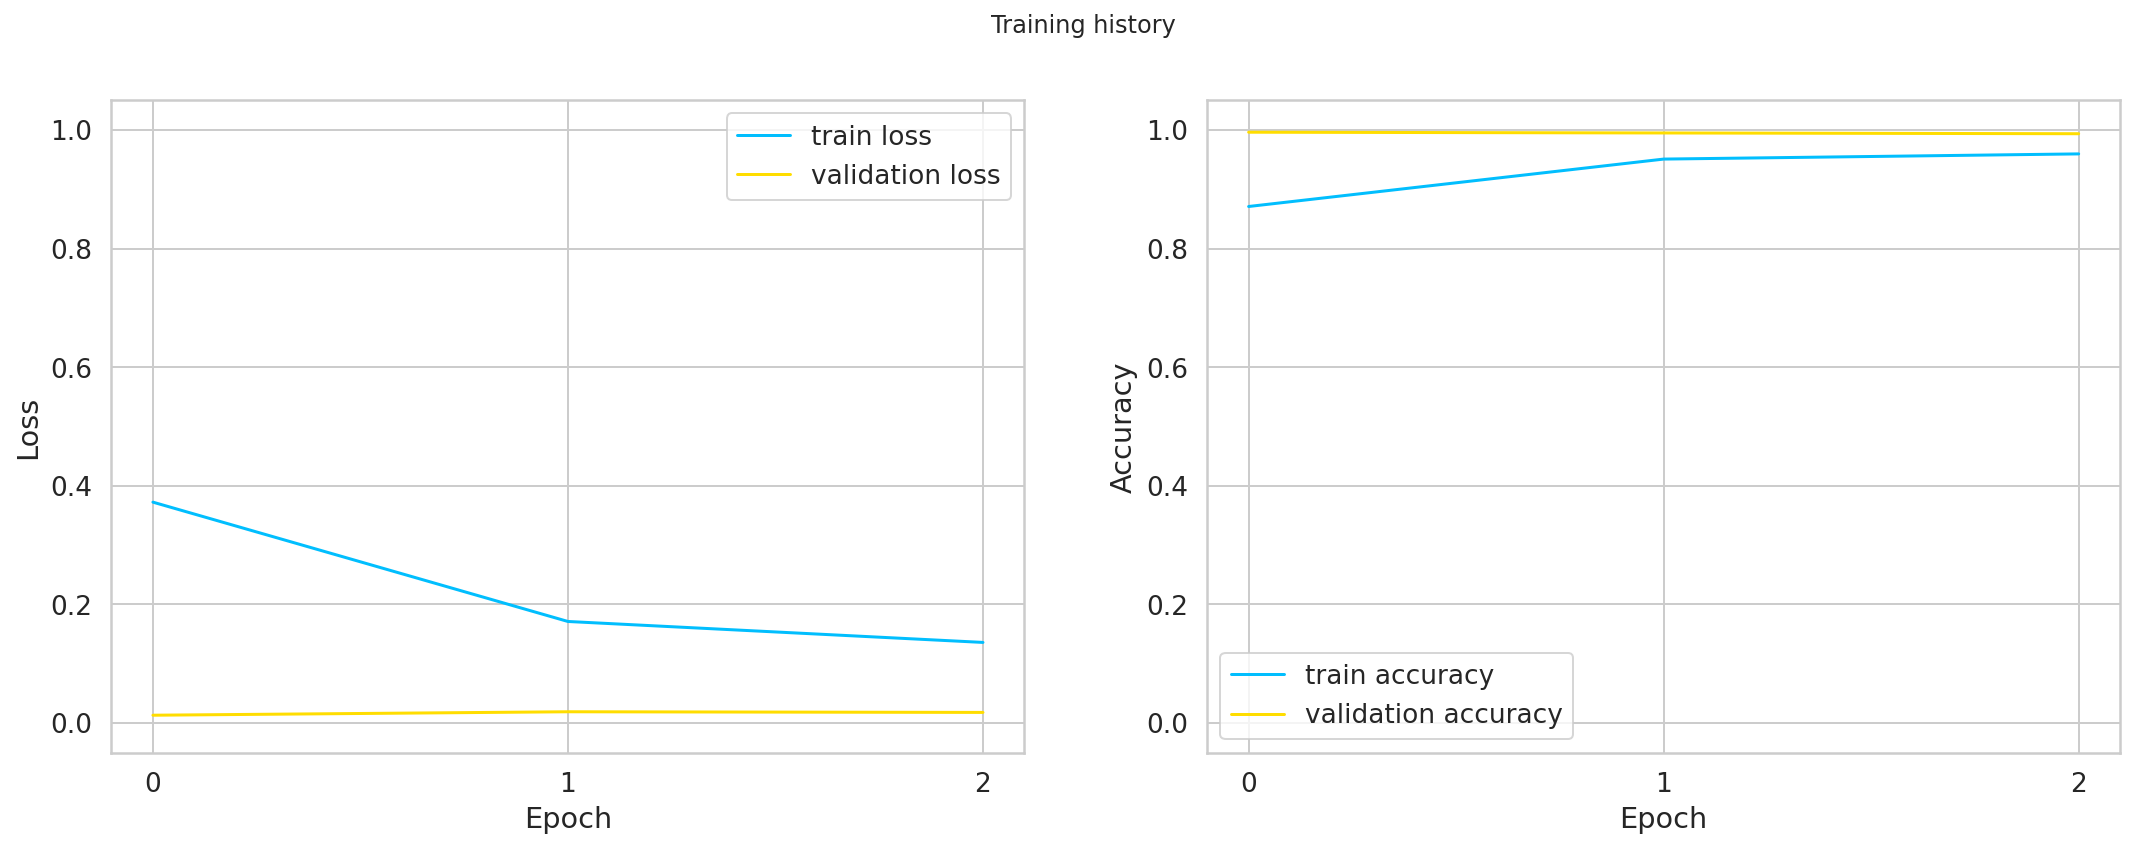

In [ ]:
plot_training_history(history)

Let's have a look at the sample image again:

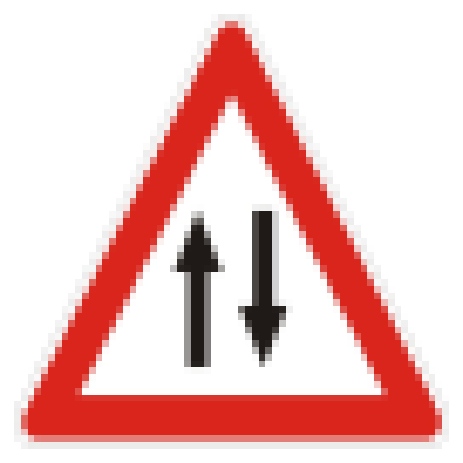

In [ ]:
show_image('unknown-sign.jpg')

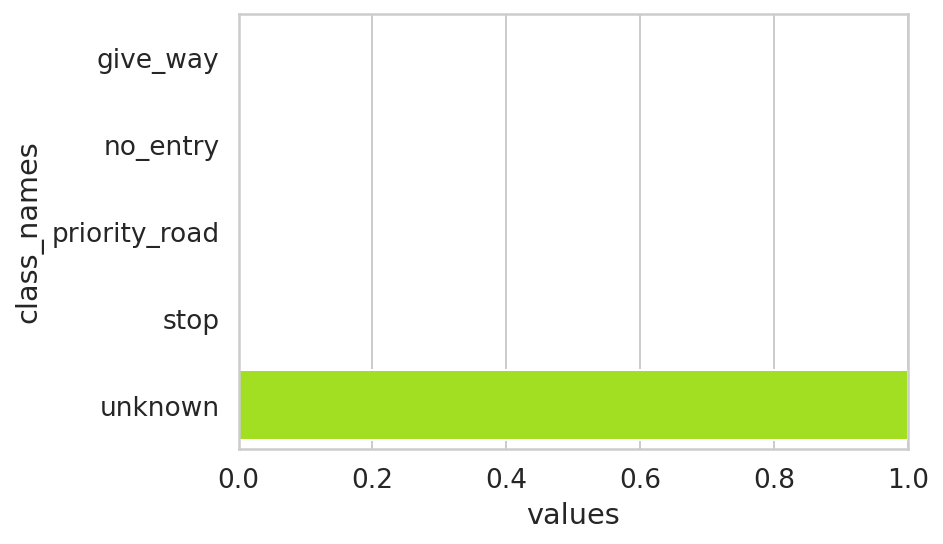

In [ ]:
pred = predict_proba(enchanced_model, 'unknown-sign.jpg')
show_prediction_confidence(pred, class_names)

Great, the model doesn't give much weight to any of the known classes. It doesn't magically know that this is a two-way sign, but recognizes is as unknown.

Let's have a look at some examples of our new dataset:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


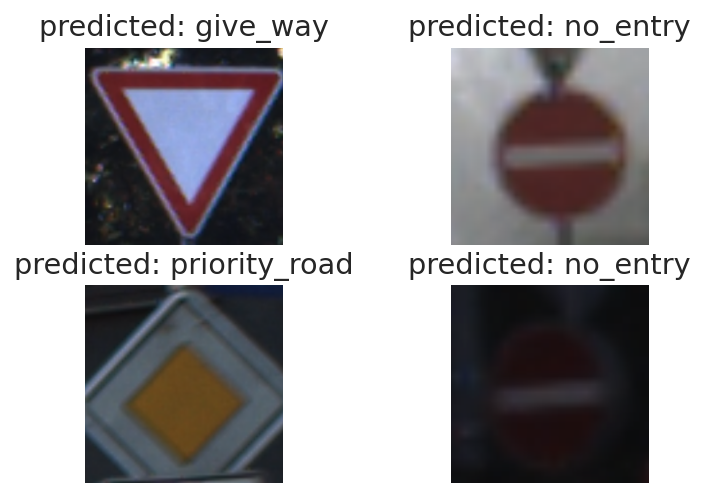

In [ ]:
show_predictions(enchanced_model, class_names, n_images=4)

Let's get an overview of the new model's performance:

In [ ]:
y_pred, y_test = get_predictions(enchanced_model, data_loaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       111
priority_road       1.00      0.99      0.99       210
         stop       1.00      1.00      1.00        78
      unknown       0.98      1.00      0.99       171

     accuracy                           1.00       786
    macro avg       1.00      1.00      1.00       786
 weighted avg       1.00      1.00      1.00       786



**References**

- Manipal University ( MAHE/ MBA- BA )
- Krish Naik Youtube Channel
- Coursera ( Google, IBM, Illinios )
- Odin School DS Boot Camp
- ChatGPT
- Google Bard